In [8]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from UQpy.surrogates import *
from scipy import special as sp
from UQpy.surrogates.polynomial_chaos.polynomials.Legendre import Legendre
from pyDOE2 import lhs
import random
from mpl_toolkits.mplot3d import Axes3D
from UQpy.distributions import Uniform, JointIndependent
from scipy.optimize import fmin_cobyla

from scipy.linalg import cho_solve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib
import pandas as pd
from scipy.optimize import fmin_cobyla
from sklearn.preprocessing import MinMaxScaler
import scipy.io

In [10]:
data = scipy.io.loadmat('OutputData_Sim_Exp.mat')
data = data['OutputData']

In [12]:
data.shape

data_matrix = np.zeros((data.shape[0]*100, data[0][0].shape[1]))

i = 0
for d in data:
    
    data_matrix[i*100: (i+1)*100,:] = d[0][101:]
    i += 1

data_matrix[:, 2] = np.round(data_matrix[:, 2])

In [14]:
nsamp = 35

ntrain = 4

#idx_train = [2, 9, 15, 29, 4, 11, 17, 31]
#idx_test = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

idx_train = [2, 9, 15, 29]
idx_test = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

#idx_train = [ 2,4,6,8,10,13,16,19,22,25,28,31]
#idx_test = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [16]:
data_train = np.zeros((ntrain*100, 6))    
data_test = np.zeros(((len(idx_test))*100, 6))

j = 0
for i in idx_train:
    data_train[j*100: (j+1)*100,:] = data_matrix[i*100: (i+1)*100,:]
    j += 1
    
l = 0    
for k in idx_test:
    data_test[l*100: (l+1)*100,:] = data_matrix[k*100: (k+1)*100,:]
    l += 1

In [18]:
X_train = data_train[:, 0:3]
y_train = data_train[:, 3:]
X_test = data_test[:, 0:3]
y_test = data_test[:, 3:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape  

((400, 3), (400, 3), (3500, 3), (3500, 3))

In [20]:
def regression_constrained(X, y, degree, X_test):

    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).ravel()
    X_test = np.asarray(X_test, dtype=float)
    mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
    X, y = X[mask], y[mask]

    poly_features = PolynomialFeatures(degree=degree, include_bias=True)
    X_poly = poly_features.fit_transform(X)
    powers = poly_features.powers_
    n_features = X_poly.shape[1]

    beta = cp.Variable(n_features)
    lambda_reg = 1e-4
    objective = cp.Minimize(cp.sum_squares(X_poly @ beta - y) + lambda_reg * cp.sum_squares(beta))

    beta_ls, _, _, _ = np.linalg.lstsq(X_poly, y, rcond=None)
    y_pred_ls = X_poly @ beta_ls
    x1_max_est = X[:, 0][np.argmax(y_pred_ls)]

    n_virtual = min(800, X_test.shape[0])  # adjust as needed
    idx_perm = np.random.permutation(X_test.shape[0])[:n_virtual]
    X_virtual = X_test[idx_perm, :]        # (n_virtual, 3)

    X_virtual_poly = poly_features.transform(X_virtual)

    D1 = np.zeros_like(X_virtual_poly)  # ∂q/∂x1
    D1_2 = np.zeros_like(X_virtual_poly)  # ∂²q/∂x1²
    D3 = np.zeros_like(X_virtual_poly)  # ∂q/∂x3
    D3_2 = np.zeros_like(X_virtual_poly)  # ∂²q/∂x3²

    x1 = X_virtual[:, 0]
    x2 = X_virtual[:, 1]
    x3 = X_virtual[:, 2]

    for j in range(n_features):
        b, c, d = powers[j]

        if b > 0:
            D1[:, j] = b * (x1 ** (b - 1)) * (x2 ** c) * (x3 ** d)
        if b > 1:
            D1_2[:, j] = b * (b - 1) * (x1 ** (b - 2)) * (x2 ** c) * (x3 ** d)
        if d > 0:
            D3[:, j] = d * (x1 ** b) * (x2 ** c) * (x3 ** (d - 1))
        if d > 1:
            D3_2[:, j] = d * (d - 1) * (x1 ** b) * (x2 ** c) * (x3 ** (d - 2))

    constraints = []
    for i in range(X_virtual.shape[0]):
        x1_i = X_virtual[i, 0]

        if x1_i <= x1_max_est:
            constraints.append(D1[i, :] @ beta >= 0)
        else:
            constraints.append(D1[i, :] @ beta <= 0)

        constraints.append(D3[i, :] @ beta >= 0)

    prob = cp.Problem(objective, constraints)

    try:
        result = prob.solve(warm_start=True)
    except Exception:
        # fallback chain if needed
        for s in ["OSQP", "SCS", "ECOS"]:
            if s in cp.installed_solvers():
                try:
                    result = prob.solve(solver=s, warm_start=True)
                    if prob.status in ("optimal", "optimal_inaccurate"):
                        break
                except Exception:
                    pass

    if beta.value is None or prob.status not in ("optimal", "optimal_inaccurate"):
        eps = 1e-10
        prob = cp.Problem(cp.Minimize(cp.sum_squares(X_poly @ beta - y)
                                      + (lambda_reg + eps) * cp.sum_squares(beta)),
                          constraints)
        prob.solve(warm_start=True)

    if beta.value is None:
        raise ValueError("Constrained optimization did not converge to a valid solution.")

    X_test_poly = poly_features.transform(X_test)
    y_pred = X_test_poly @ beta.value
    return y_pred


In [22]:
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [24]:
degree = 6
q = regression_constrained(X_train_scaled, y_train[:,1], degree, X_test_scaled)

In [25]:
# --- PRECOMPUTE derivative targets on the test grid (ONE TIME) ---
Δ = 1.0
X_plus  = X_test.copy();  X_plus[:,  2] += Δ
X_minus = X_test.copy();  X_minus[:, 2] -= Δ

X_plus_scaled  = scaler_X.transform(X_plus)
X_minus_scaled = scaler_X.transform(X_minus)

# Each call solves the constrained polynomial ONCE (outside optimizer)
eps_plus  = regression_constrained(X_train_scaled, y_train[:, 1], degree, X_plus_scaled)
eps_minus = regression_constrained(X_train_scaled, y_train[:, 1], degree, X_minus_scaled)

# Central difference target on the test grid
dqdP_test = (np.asarray(eps_plus).ravel() - np.asarray(eps_minus).ravel()) / (2.0 * Δ)
S = np.median(np.abs(dqdP_test)) + 1e-12
# Fit a small surrogate for derivative mean: X -> dq/dP
# (smaller degree is fine; 3–4 is usually enough and fast)
poly_prime  = PolynomialFeatures(degree=min(4, degree), include_bias=True)
X_poly_test = poly_prime.fit_transform(X_test_scaled)
reg_prime   = LinearRegression().fit(X_poly_test, dqdP_test.reshape(-1, 1))

def regression_mean_prime_q_fast(X_virtual_scaled):
    """Cheap derivative mean via the surrogate (no CVX inside optimizer)."""
    return reg_prime.predict(poly_prime.transform(X_virtual_scaled)).ravel()


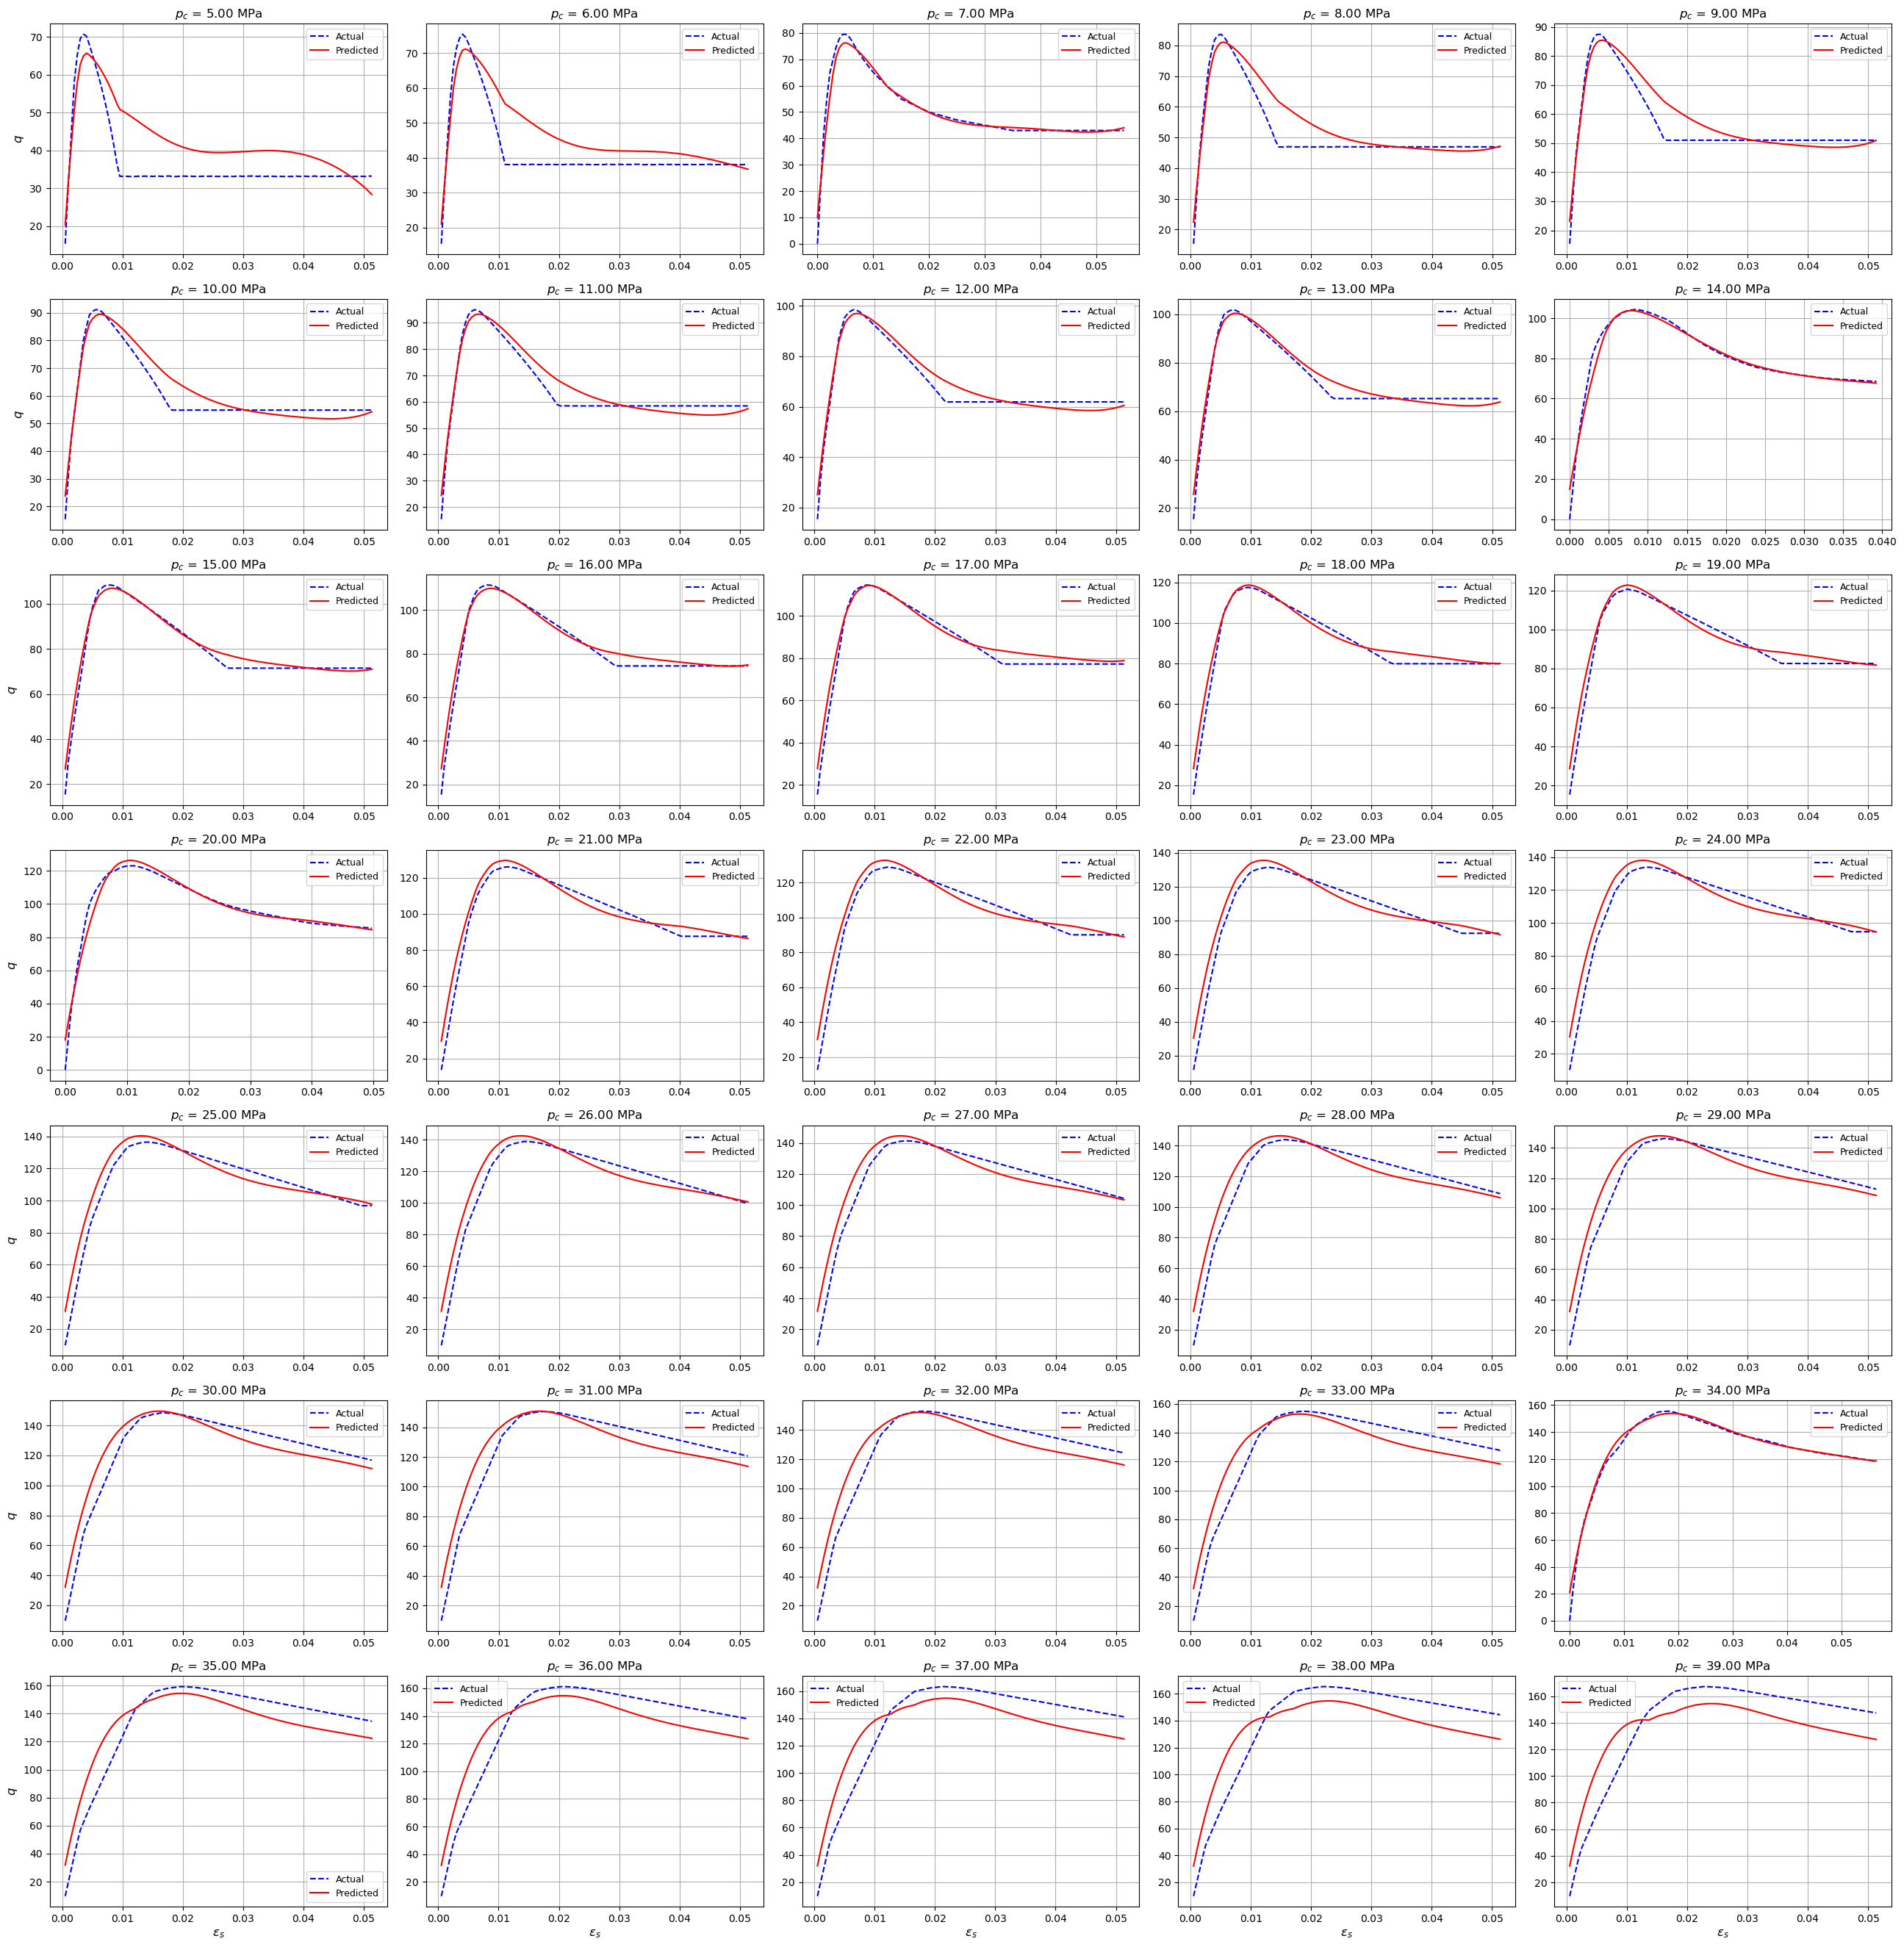

In [26]:
pc = np.linspace(5,39,35)

n_groups = len(pc)              # 34
pts_per_group = X_test.shape[0] // n_groups  # expected 100

# layout: 7 rows x 5 cols = 35 slots; we'll hide the last unused one
ncols = 5
nrows = int(np.ceil(n_groups / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 3.8*nrows))
axes = np.atleast_2d(axes)

for i in range(n_groups):
    r, c = divmod(i, ncols)
    ax = axes[r, c]
    s = i * pts_per_group
    e = s + pts_per_group

    # plots
    ax.plot(X_test[s:e, 0], y_test[s:e, 1], label='Actual', linestyle='dashed', color='blue')
    ax.plot(X_test[s:e, 0], q[s:e],         label='Predicted',                    color='red')

    # title using your existing mapping through idx_test
    ax.set_title(fr'$p_c$ = {pc[idx_test[i]]:.2f} MPa', fontsize=12)

    # axes labels (to reduce clutter, only on left/bottom)
    if r == nrows - 1:
        ax.set_xlabel(r'$\epsilon_{s}$', fontsize=12)
    if c == 0:
        ax.set_ylabel(r'$q$', fontsize=12)

    ax.grid(True)

    # legend on each panel (you can comment this out and keep only the first if cluttered)
    ax.legend(loc='best', fontsize=9)

# hide any unused axes (e.g., the 35th slot)
for j in range(n_groups, nrows * ncols):
    rr, cc = divmod(j, ncols)
    axes[rr, cc].axis('off')

plt.tight_layout()
plt.show()

In [30]:
def Kernel(x1, x2, l1, l2, l3, sigma_f):
    
    theta = np.array([1/(2*l1**2), 1/(2*l2**2), 1/(2*l3**2)])
    
    diff_x = x1[:, None, :] - x2[None, :, :]
    sq_diff_x = diff_x ** 2
    exp_term = np.exp(-np.sum(theta * sq_diff_x, axis=2))
    
    K = sigma_f**2 * exp_term 
    #+ np.eye(x1.shape[0],x2.shape[0]) * (sigma_n)**2
    

    return K

In [32]:
def regression_mean_prime_q(X_virtual, X_train_scaled, X_test_scaled, q_pred, degree=6):
    """
    Estimate mean derivative ∂q/∂P at X_virtual by:
      1) Central finite difference in the ORIGINAL pressure axis (±Δ),
      2) Re-evaluating the constrained polynomial mean at X_test_scaled±,
      3) Regressing (X_test_scaled → derivative) and predicting at X_virtual.
    """
    X_virtual = np.asarray(X_virtual, float)
    X_train_scaled = np.asarray(X_train_scaled, float)
    X_test_scaled = np.asarray(X_test_scaled, float)

    X_test_unscaled = scaler_X.inverse_transform(X_test_scaled)

    Δ = 1

    X_plus  = X_test_unscaled.copy()
    X_minus = X_test_unscaled.copy()
    X_plus[:,  2] += Δ
    X_minus[:, 2] -= Δ

    X_plus_scaled  = scaler_X.transform(X_plus)
    X_minus_scaled = scaler_X.transform(X_minus)

    eps_plus  = regression_constrained(X_train_scaled, y_train[:, 1], degree, X_plus_scaled)
    eps_minus = regression_constrained(X_train_scaled, y_train[:, 1], degree, X_minus_scaled)

    dqdP_test = (np.asarray(eps_plus).ravel() - np.asarray(eps_minus).ravel()) / (2.0 * Δ)

    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X_poly_test = poly.fit_transform(X_test_scaled)
    reg_prime = LinearRegression().fit(X_poly_test, dqdP_test.reshape(-1, 1))

    X_poly_virtual = poly.transform(X_virtual)
    pred_deriv = reg_prime.predict(X_poly_virtual)

    return pred_deriv



In [34]:
def Kernel_prime_q(x1, x2, l1, l2, l3, sigma_f):
    # Compute the exponential part of the squared-exponential kernel.
    theta = np.array([1/(2*l1**2), 1/(2*l2**2), 1/(2*l3**2)])
    diff_x = x1[:, None, :] - x2[None, :, :]   # shape: (n_test, n_train, d)
    sq_diff_x = diff_x ** 2
    exp_term = np.exp(-np.sum(theta * sq_diff_x, axis=2))
    
    # Compute differences in the second coordinate.
    diff_eps = x1[:, None, 2] - x2[None, :, 2]
    
    # Compute the second mixed derivative covariance:
    K = sigma_f**2 * exp_term * (1/(l3**2) - (diff_eps**2)/(l3**4))
    
    # Add noise variance on the diagonal if x1 and x2 are the same.
    #if x1.shape[0] == x2.shape[0]:
    #    K += np.eye(x1.shape[0]) * sigma_n**2
    
    return K

In [36]:
def mle(theta, x_train, y_train, mean_regression):
    
    l1, l2, l3, sigma_f, sigma_n = 10**theta  
    n1 = x_train.shape[0]      
    K = Kernel(x_train, x_train, l1, l2, l3, sigma_f) + np.eye(n1) * (sigma_n)**2 + np.eye(n1)*1e-8
    # Eigenvalue analysis for diagnostic purposes
    #eigenvalues = np.linalg.eigvals(K)
    #print("Eigenvalues of K:", eigenvalues)
    L = np.linalg.cholesky(K)
    var = ((y_train - mean_regression).T @ (cho_solve((L, True), y_train - mean_regression))) 
    LnofDetK = 2*np.sum(np.log(np.abs(np.diag(L)))) 
    le = -(1/2)*var - 0.5*LnofDetK - ((n1)/2)*np.log(2*np.pi)
    
    return -le.flatten()

In [38]:
def predict(theta, x_train, y_train, x_test, mean_regression, mu_test_reg):
    
    l1, l2, l3, sigma_f, sigma_n = 10**theta  
    n1 = x_train.shape[0]      
    k12 = Kernel(x_train, x_test, l1, l2, l3, sigma_f)
    k21 = Kernel(x_test, x_train, l1, l2, l3, sigma_f)
    k22 = Kernel(x_test, x_test, l1, l2, l3, sigma_f)
    K = Kernel(x_train, x_train, l1, l2, l3, sigma_f) + np.eye(n1) * (sigma_n)**2 + np.eye(n1)*1e-8 
    L = np.linalg.cholesky(K)
    alpha = cho_solve((L, True), y_train - mean_regression)
    y_gp = mu_test_reg + k21 @ alpha
    varr = k22 - k21 @ cho_solve((L, True), k12)
    pred_var = np.diag(varr)
    pred_std = np.sqrt(pred_var)

    return y_gp.flatten(), pred_std.flatten()

In [40]:
def predict_prime_q(theta, X_train, x_virtual):
    # --- Mean of derivative from fast surrogate (NO CVX HERE) ---
    dmu = regression_mean_prime_q_fast(x_virtual)

    # --- θ-dependent uncertainty from derivative kernel ---
    l1, l2, l3, sigma_f, sigma_n = 10**theta
    n1 = X_train.shape[0]

    K11 = Kernel_prime_q(X_train,  X_train,  l1, l2, l3, sigma_f)
    K12 = Kernel_prime_q(X_train,  x_virtual, l1, l2, l3, sigma_f)
    K21 = K12.T
    K22 = Kernel_prime_q(x_virtual, x_virtual, l1, l2, l3, sigma_f)

    # Scaled jitter for numerical stability
    diag_mean = float(max(1e-12, np.mean(np.diag(K11))))
    jitter = (10**theta[-1])**2 + 1e-6 * diag_mean  # sigma_n^2 + scaled jitter

    try:
        L = np.linalg.cholesky(K11 + jitter * np.eye(n1))
        varr = K22 - K21 @ cho_solve((L, True), K12)
        pred_var = np.clip(np.diag(varr), 0.0, None)
    except np.linalg.LinAlgError:
        # Conservative fallback: prior variance only
        pred_var = np.clip(np.diag(K22) + (10**theta[-1])**2, 0.0, None)

    return dmu, pred_var

In [42]:
# ---- freeze virtual points once (global) ----
np.random.seed(42)
N_VIRTUAL = 120
_idx = np.random.permutation(X_test_scaled.shape[0])[:N_VIRTUAL]
X_VIRTUAL_FIXED = X_test_scaled[_idx, :]



In [44]:
def constraint_q(theta):
    # --- Sample virtual points from the test domain ---
    n_virtual = 120
    idx = np.random.permutation(X_test_scaled.shape[0])[:n_virtual]
    X_virtual = X_test_scaled[idx, :]  # (n_virtual, 3)

    # --- Derivative (wrt pressure) mean & variance from derivative GP ---
    dmu, pred_var_prime = predict_prime_q(theta, X_train_scaled, X_virtual)
    # make sure shapes and values are sane
    dmu = np.asarray(dmu, dtype=float).reshape(-1)
    pred_var_prime = np.asarray(pred_var_prime, dtype=float).reshape(-1)
    dstd = np.sqrt(np.clip(pred_var_prime, 0.0, None))

    # --- One-sided chance constraint: dq/dP >= 0 with z-sigma margin ---
    z = 1.96  # ~95% one-sided
    constraints = dmu - z * dstd  # each element must be >= 0 for feasibility

    return np.asarray(constraints, dtype=float)


In [46]:
mu_q = regression_constrained(X_train_scaled, y_train[:,1], degree, X_train_scaled)
#mu_q = regression_constrained(X_train_scaled, y_train[:,1], degree, X_test_scaled)
q_pred = regression_constrained(X_train_scaled, y_train[:,1], degree, X_test_scaled)

In [47]:
%matplotlib widget

In [50]:
# Convert input data
q_pred = np.array(q_pred).flatten()    # shape: (4200,)

# Extract input columns
dev_strain = X_test_scaled[:, 0]
vol_strain = X_test_scaled[:, 1]
pressure = X_test_scaled[:, 2]

# Assumption: Pressure is constant across all 4200 entries
# Now reshape to (42, 100): 42 dev_strain levels × 100 vol_strain levels
dev_strain = dev_strain.reshape(35, 100)
vol_strain = vol_strain.reshape(35, 100)
q_pred = q_pred.reshape(35, 100)


In [52]:
Δ = 1
X_plus  = X_test.copy()
X_minus = X_test.copy()
X_plus[:, 2]  += Δ
X_minus[:, 2] -= Δ
#X_plus[0:99, 0] = X_plus[400:499, 0]
#X_plus[0:99, 1] = X_plus[400:499, 1]
X_plus_scaled = scaler_X.transform(X_plus)
X_minus_scaled = scaler_X.transform(X_minus)
eps_plus  = regression_constrained(X_train_scaled, y_train[:,1], degree, X_plus_scaled)
eps_minus = regression_constrained(X_train_scaled, y_train[:,1], degree, X_minus_scaled)
deps_dP = (eps_plus - eps_minus) / (2 * Δ)
q_pred = np.array(q_pred).flatten()
ratio = (q_pred / X_test[:,2]) / deps_dP  

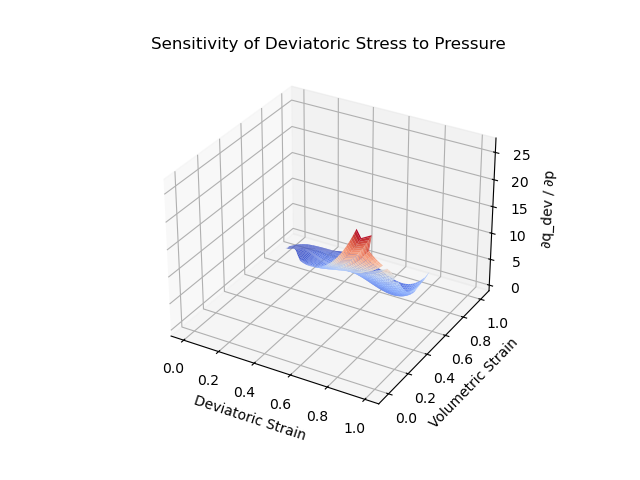

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume these are reshaped to (42, 100)
dev_strain = dev_strain.reshape(35, 100)
vol_strain = vol_strain.reshape(35, 100)
deps_dP = deps_dP.reshape(35, 100)  # your computed slope

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(dev_strain, vol_strain, deps_dP, cmap='coolwarm')

ax.set_xlabel("Deviatoric Strain")
ax.set_ylabel("Volumetric Strain")
ax.set_zlabel("∂q_dev / ∂p")
ax.set_title("Sensitivity of Deviatoric Stress to Pressure")

plt.show()

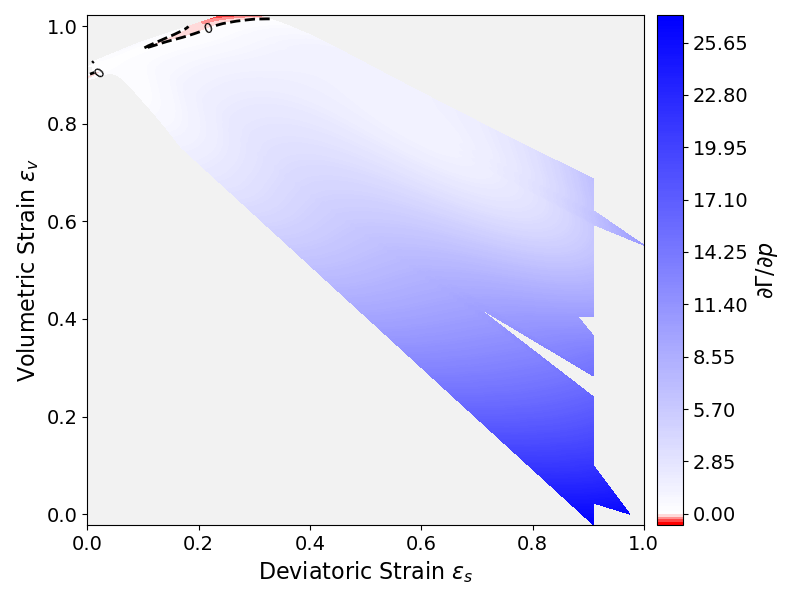

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- Inputs ---
# dev_strain: (34, 100)
# vol_strain: (34, 100)
# deps_dP:    (34, 100)

Z = np.array(deps_dP, dtype=float)
if np.isnan(Z).any():
    Z = np.ma.array(Z, mask=np.isnan(Z))

# Get min and max
zmin = float(np.nanmin(Z))
zmax = float(np.nanmax(Z))

# If most values are >= 0, we still keep white at 0, red < 0, blue > 0
# but let the vmax stretch naturally to your data
norm = colors.TwoSlopeNorm(vmin=zmin, vcenter=0.0, vmax=zmax)

# Red → White → Blue colormap
cmap = colors.LinearSegmentedColormap.from_list(
    "red_white_blue", [(0.0, "red"), (0.5, "white"), (1.0, "blue")]
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor("#f2f2f2")
# Filled contour
cf = ax.contourf(dev_strain, vol_strain, Z, levels=200, cmap=cmap, norm=norm)

# Optional: mark zero contour if negatives exist
if zmin < 0:
    c0 = ax.contour(dev_strain, vol_strain, Z, levels=[0.0],
                    colors='k', linewidths=2, linestyles='--')
    ax.clabel(c0, fmt={0.0: '0'}, inline=True, fontsize=10)

# Labels
ax.set_xlabel("Deviatoric Strain $\epsilon_{s}$",fontsize=16)
ax.set_ylabel("Volumetric Strain $\epsilon_{v}$",fontsize=16)
#ax.set_title("Projection: Sensitivity of Deviatoric Stress to Pressure")

# Colorbar
cbar = fig.colorbar(cf, ax=ax, pad=0.02)
cbar.set_label(r'$\partial \Gamma / \partial p$',fontsize=16)

ax.tick_params(axis='both', labelsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()


In [180]:
from pyDOE2 import lhs
from scipy.optimize import minimize, Bounds
import numpy as np

def optimize(neglikelihood, constraint=True, seed=44):
    n = 10
    optimeth = 'COBYLA'
    
    lb = np.array([-4.0, -4.0, -4.0, -4.0, -10.0])
    ub = np.array([ 2.0,  2.0, -1.5,  2.0,  -2.0])
    
    # Deterministic LHS starts (same 10 x0 every run with the same seed)
    lhd = lhs(5, n, criterion='maximin', random_state=seed)
    x0  = (ub - lb) * lhd + lb

    optibounds = Bounds(lb, ub)
    
    feasible_thetas = []
    feasible_fun = []
    feasible_maxcv = []
    
    # Set up constraints based on the flag.
    if constraint:
        constraints_list = [{"type": "ineq", "fun": constraint_q}]
    else:
        constraints_list = []  # no constraints
    
    tol = 1  # tolerance for maximum constraint violation
    
    for i in range(n):
        print(f"Starting optimization for sample {i+1}...")
        res = minimize(
            neglikelihood,
            x0[i, :].T,
            method=optimeth,
            bounds=optibounds,  # note: COBYLA ignores 'bounds'; kept to match your original signature
            constraints=constraints_list,
            options={'maxiter': 1000, 'disp': True, 'catol': 1}
        )
        print(f"Optimization {i+1} completed.")
        print(f"Result: {res}")
        
        # Use res.maxcv to determine feasibility.
        if res.maxcv <= tol:
            feasible_thetas.append(res.x)
            feasible_fun.append(res.fun)
            feasible_maxcv.append(res.maxcv)
        else:
            print(f"Candidate solution from sample {i+1} violates constraints (maxcv = {res.maxcv}).")
    
    if feasible_thetas:
        feasible_thetas = np.array(feasible_thetas)
        feasible_fun = np.array(feasible_fun)
        best_idx = np.argmin(feasible_fun)
        theta = feasible_thetas[best_idx]
        print(f"Best feasible theta: {theta} with objective value: {feasible_fun[best_idx]} and maxcv: {feasible_maxcv[best_idx]}")
    else:
        raise ValueError("No candidate solution satisfied the constraints based on maxcv.")
    
    return theta

In [182]:
def neglikelihood_q(theta):
    return mle(theta, X_train_scaled, y_train[:,1].reshape(-1,1), mu_q.reshape(-1,1))

In [184]:
thetaopt_q = optimize(neglikelihood_q, constraint=True, seed=44)

Starting optimization for sample 1...
Optimization 1 completed.
   Normal return from subroutine COBYLA

Result:  message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
 success: False
  status: 4
     fun: 36196.25298125405
       x: [-1.935e+00 -7.092e-01 -1.017e+00 -8.575e-01 -1.459e+00]
    nfev: 55
   maxcv: 2.8454658408178615
Candidate solution from sample 1 violates constraints (maxcv = 2.8454658408178615).
Starting optimization for sample 2...

   NFVALS =   55   F = 3.619625E+04    MAXCV = 2.845466E+00
   X =-1.935199E+00  -7.092378E-01  -1.017273E+00  -8.574511E-01  -1.458992E+00
Optimization 2 completed.
   Normal return from subroutine COBYLA

   NFVALS =   57   F = 1.393205E+03    MAXCV = 8.419177E+00
   X =-5.950558E-01  -4.062740E+00  -4.868007E-01   1.386787E-01  -8.878319E+00

Result:  message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
 success: False
  status:

In [186]:
#thetaopt_q = np.array([-2.11052113, 1.40342778, -1.50136799, -2.82381956, -9.78397264])

In [188]:
q_gp, q_std = predict(thetaopt_q, X_train_scaled, y_train[:,1].reshape(-1,1), X_test_scaled, mu_q.reshape(-1,1), q.reshape(-1,1))

In [190]:
print(thetaopt_q)

[-2.11052113  1.40342778 -1.50136799 -2.82381956 -9.78397264]


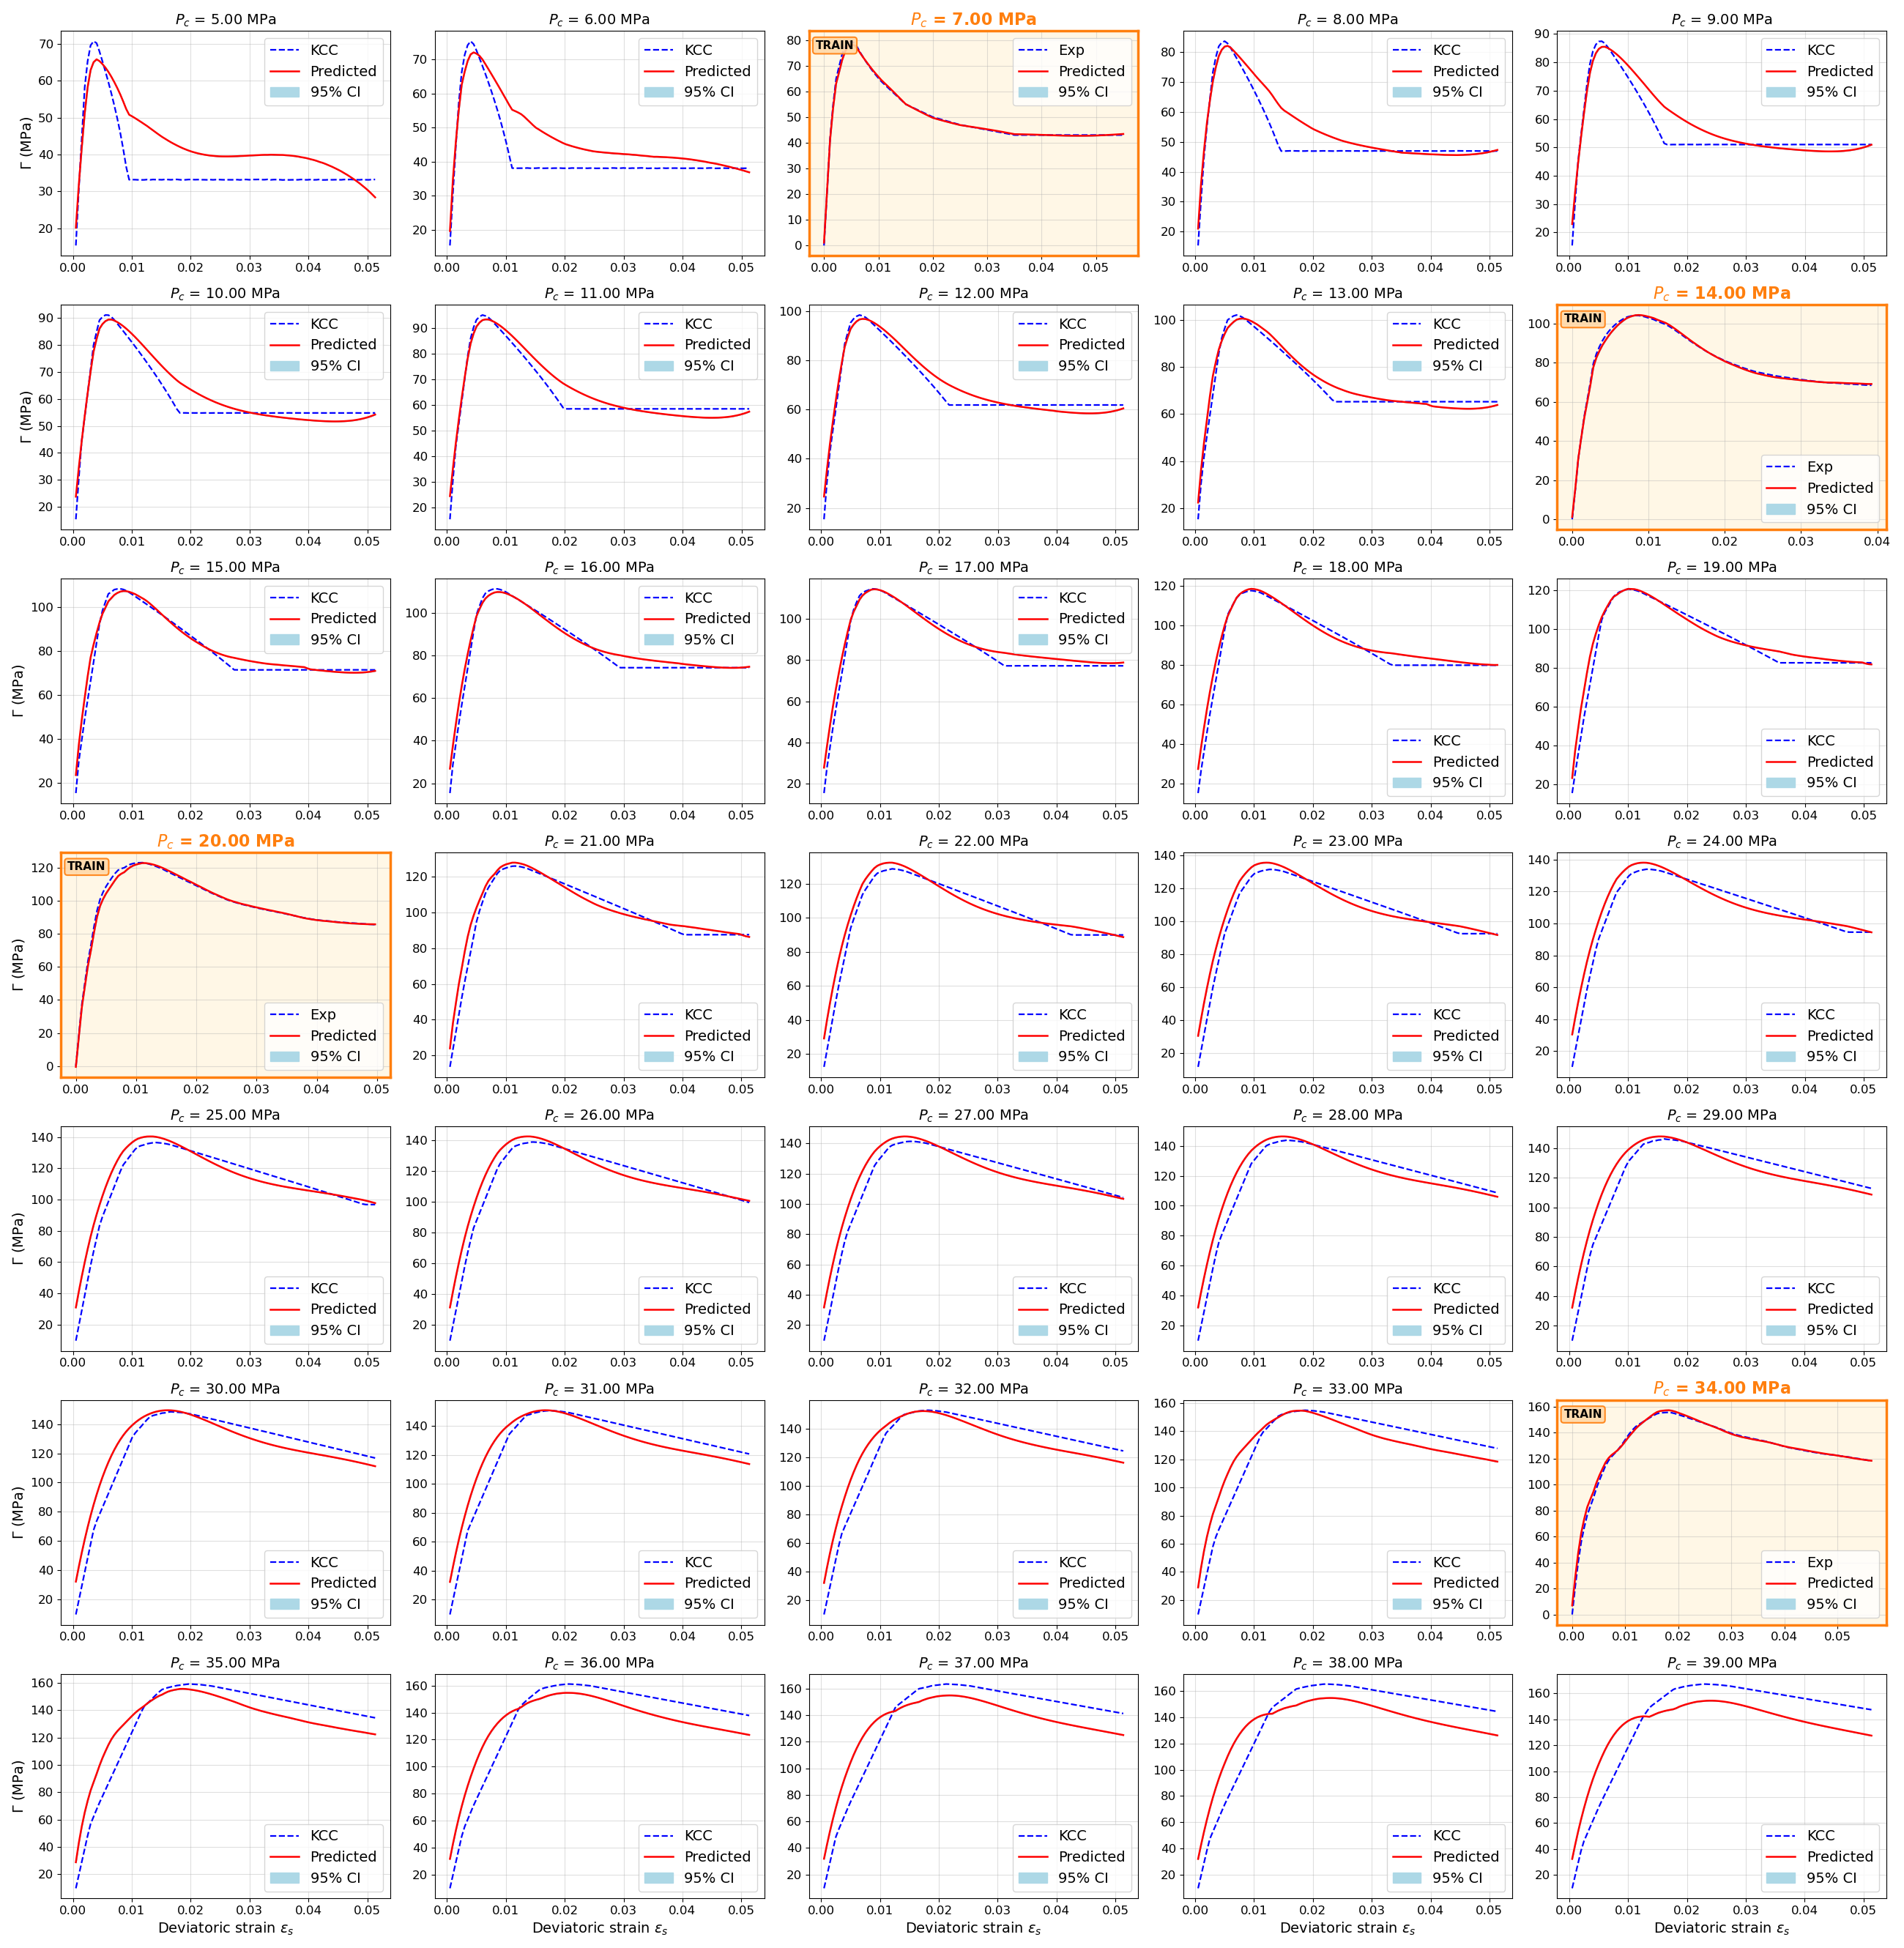

In [226]:
import numpy as np
import matplotlib.pyplot as plt

# assume: X_test, y_test, q_gp, q_std, pc, idx_test, idx_train are already defined
n_groups = len(idx_test)
N = X_test.shape[0]

# fast membership test
train_set = set(idx_train)

# figure layout
ncols = 5
nrows = int(np.ceil(n_groups / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 3.8*nrows))
axes = np.atleast_2d(axes).ravel()

# determine slices per group
if N % n_groups == 0:
    pts_per = N // n_groups
    bounds = [i*pts_per for i in range(n_groups)] + [N]
else:
    bounds = np.linspace(0, N, n_groups+1, dtype=int)

for i in range(n_groups):
    ax = axes[i]
    s, e = bounds[i], bounds[i+1]

    x = X_test[s:e, 0]
    y_true = y_test[s:e, 1]
    y_mean = q_gp[s:e]
    y_ci   = 1.96 * q_std[s:e]

    # determine if this panel corresponds to a training pressure
    group_idx = idx_test[i]
    is_train = group_idx in train_set

    # set label depending on training/test
    label_true = 'Exp' if is_train else 'KCC'

    # plots
    ax.plot(x, y_true, label=label_true, linestyle='dashed', color='blue', linewidth=1.6)
    ax.plot(x, y_mean, label='Predicted', color='red', linewidth=1.8)
    ax.fill_between(x, y_mean - y_ci, y_mean + y_ci, alpha=1, color='lightblue', label='95% CI')

    # title with pressure label
    title_txt = fr'$P_c$ = {pc[group_idx]:.2f} MPa'
    if is_train:
        ax.set_title(title_txt, fontsize=16, fontweight='bold', color='tab:orange')
        # subtle background highlight
        ax.set_facecolor('#fff7e6')  # light orange
        # thicker, colored spines
        for sp in ax.spines.values():
            sp.set_linewidth(2.5)
            sp.set_edgecolor('tab:orange')
        # small badge in top-left of axes
        ax.text(0.02, 0.96, 'TRAIN', transform=ax.transAxes,
                ha='left', va='top',
                fontsize=11, fontweight='bold',
                color='black',
                bbox=dict(boxstyle='round,pad=0.25', facecolor='#ffd8a8',
                          edgecolor='tab:orange', linewidth=1.5, alpha=0.9))
    else:
        ax.set_title(title_txt, fontsize=14)

    ax.grid(True, alpha=0.4)

    # axis labels (reduce clutter)
    r, c = divmod(i, ncols)
    if r == nrows - 1:
        ax.set_xlabel(r'Deviatoric strain $\epsilon_{s}$', fontsize=14)
    if c == 0:
        ax.set_ylabel(r'$\Gamma$ (MPa)', fontsize=14)

    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=14, loc='best')

# hide any unused axes
for j in range(n_groups, nrows*ncols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [193]:
q_gp_prime, q_std_prime = predict_prime_q(thetaopt_q, X_train_scaled, X_test_scaled)

In [196]:
import numpy as np

def compute_segmented_rmse_nrmse(y_test, q_gp, segment_size=100):
    """
    Compute RMSE and NRMSE between y_test[:, 1] (true) and q_gp (predicted) in segments.

    Parameters
    ----------
    y_test : ndarray, shape (n_samples, 3)
        Ground truth data array (second column is the true q).
    q_gp : ndarray, shape (n_samples,)
        GP-predicted mean values.
    segment_size : int
        Number of points per segment.

    Returns
    -------
    rmse_list : list of float
        RMSE values for each segment.
    nrmse_list : list of float
        NRMSE values (as percentages) for each segment.
    """
    y_true = y_test[:, 1]
    n_segments = len(q_gp) // segment_size
    rmse_list = []
    nrmse_list = []

    for i in range(n_segments):
        start = i * segment_size
        end = start + segment_size
        y_seg = y_true[start:end]
        q_seg = q_gp[start:end]

        mse = np.mean((q_seg - y_seg) ** 2)
        rmse = np.sqrt(mse)
        y_range = np.max(y_seg) - np.min(y_seg)

        if y_range == 0:
            nrmse = np.nan
        else:
            nrmse = (rmse / y_range) * 100  # normalize by true data range

        rmse_list.append(rmse)
        nrmse_list.append(nrmse)

    return rmse_list, nrmse_list

# Example usage
rmse_values, nrmse_values = compute_segmented_rmse_nrmse(y_test, q_gp)

for i, (rmse, nrmse) in enumerate(zip(rmse_values, nrmse_values), 1):
    print(f"Segment {i:02d}: RMSE = {rmse:.4f}, NRMSE = {nrmse:.2f}%")


Segment 01: RMSE = 7.9227, NRMSE = 14.32%
Segment 02: RMSE = 6.7041, NRMSE = 11.16%
Segment 03: RMSE = 0.5766, NRMSE = 0.73%
Segment 04: RMSE = 5.2795, NRMSE = 7.74%
Segment 05: RMSE = 4.7891, NRMSE = 6.64%
Segment 06: RMSE = 4.2877, NRMSE = 5.66%
Segment 07: RMSE = 3.8016, NRMSE = 4.77%
Segment 08: RMSE = 3.3318, NRMSE = 4.01%
Segment 09: RMSE = 3.0531, NRMSE = 3.53%
Segment 10: RMSE = 0.8017, NRMSE = 0.77%
Segment 11: RMSE = 3.1781, NRMSE = 3.42%
Segment 12: RMSE = 3.2617, NRMSE = 3.39%
Segment 13: RMSE = 3.7828, NRMSE = 3.81%
Segment 14: RMSE = 3.9726, NRMSE = 3.89%
Segment 15: RMSE = 4.4395, NRMSE = 4.21%
Segment 16: RMSE = 1.4522, NRMSE = 1.18%
Segment 17: RMSE = 5.3343, NRMSE = 4.74%
Segment 18: RMSE = 5.9100, NRMSE = 5.08%
Segment 19: RMSE = 6.5223, NRMSE = 5.44%
Segment 20: RMSE = 7.1402, NRMSE = 5.77%
Segment 21: RMSE = 7.6425, NRMSE = 6.03%
Segment 22: RMSE = 8.0202, NRMSE = 6.21%
Segment 23: RMSE = 8.4544, NRMSE = 6.42%
Segment 24: RMSE = 8.9331, NRMSE = 6.66%
Segment 25: RM

In [198]:
import numpy as np

def compute_segmented_r2(y_test, q_gp, segment_size=100):
    """
    Compute R² between GP predictions (q_gp) and ground truth (y_test[:, 1]) in segments.
    """
    y_true = y_test[:, 1]
    n_segments = len(q_gp) // segment_size
    r2_list = []

    for i in range(n_segments):
        start = i * segment_size
        end = start + segment_size
        y_seg = y_true[start:end]
        q_seg = q_gp[start:end]

        ss_res = np.sum((y_seg - q_seg) ** 2)                # residuals
        ss_tot = np.sum((y_seg - np.mean(y_seg)) ** 2)       # total variance
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan  # avoid divide-by-zero

        r2_list.append(r2)

    return r2_list

# Example usage:
r2_values = compute_segmented_r2(y_test, q_gp)

for i, r2 in enumerate(r2_values, 1):
    print(f"Segment {i:02d}: R² = {r2:.4f}")


Segment 01: R² = 0.3803
Segment 02: R² = 0.6047
Segment 03: R² = 0.9978
Segment 04: R² = 0.8001
Segment 05: R² = 0.8505
Segment 06: R² = 0.8913
Segment 07: R² = 0.9223
Segment 08: R² = 0.9458
Segment 09: R² = 0.9585
Segment 10: R² = 0.9979
Segment 11: R² = 0.9626
Segment 12: R² = 0.9641
Segment 13: R² = 0.9559
Segment 14: R² = 0.9556
Segment 15: R² = 0.9490
Segment 16: R² = 0.9947
Segment 17: R² = 0.9375
Segment 18: R² = 0.9290
Segment 19: R² = 0.9199
Segment 20: R² = 0.9110
Segment 21: R² = 0.9043
Segment 22: R² = 0.8999
Segment 23: R² = 0.8947
Segment 24: R² = 0.8891
Segment 25: R² = 0.8832
Segment 26: R² = 0.8768
Segment 27: R² = 0.8699
Segment 28: R² = 0.8616
Segment 29: R² = 0.8503
Segment 30: R² = 0.9938
Segment 31: R² = 0.8307
Segment 32: R² = 0.8168
Segment 33: R² = 0.7988
Segment 34: R² = 0.7774
Segment 35: R² = 0.7514


In [200]:
R = scaler_X.data_max_[2] - scaler_X.data_min_[2]
print(R)

27.0


In [202]:
print(q_std_prime)

[0.00208066 0.00208254 0.00208469 ... 0.00226515 0.00226515 0.00226515]


In [204]:
q_gp_prime = q_gp_prime.reshape(35, 100)
q_std_prime = q_std_prime.reshape(35, 100)

In [206]:
consq = q_gp_prime - 1.96*np.sqrt(q_std_prime)

In [208]:
print(consq)

[[2.57613117e-02 1.63867780e-03 4.76759146e-03 ... 2.62462138e+01
  2.68364686e+01 2.74305838e+01]
 [4.84471633e-02 1.30366018e-02 6.83724812e-03 ... 2.40874138e+01
  2.46133362e+01 2.51482299e+01]
 [2.46885222e-01 1.58618410e-01 1.13416599e-01 ... 2.57965662e+01
  2.63543970e+01 2.69228176e+01]
 ...
 [1.41575095e-01 1.85849144e-01 2.28878229e-01 ... 5.53352550e+00
  5.93275324e+00 6.33422139e+00]
 [3.15552425e-01 3.72482200e-01 4.25263511e-01 ... 5.74397264e+00
  6.16409186e+00 6.58679754e+00]
 [5.31891334e-01 6.01506425e-01 6.64092998e-01 ... 6.06233376e+00
  6.49417720e+00 6.94696718e+00]]


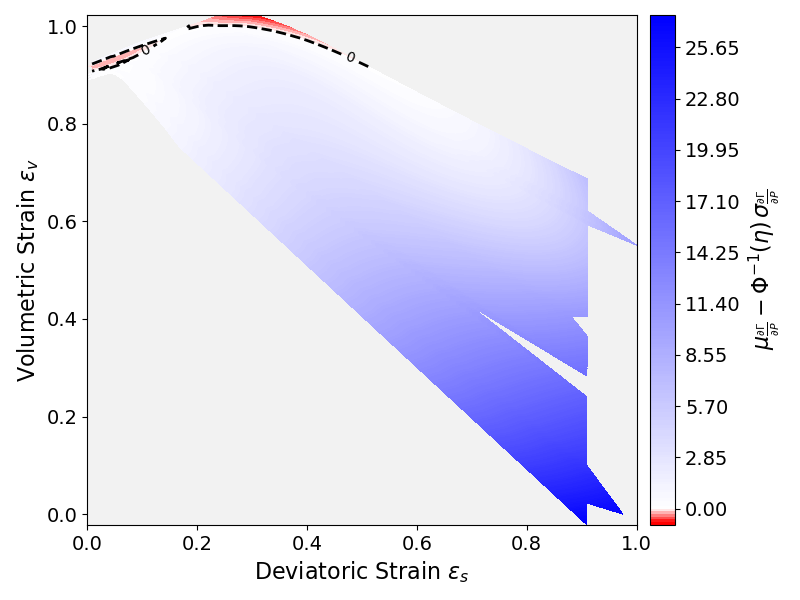

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- Inputs ---
# dev_strain: (34, 100)
# vol_strain: (34, 100)
# deps_dP:    (34, 100)

Z = np.array(consq, dtype=float)
if np.isnan(Z).any():
    Z = np.ma.array(Z, mask=np.isnan(Z))

# Get min and max
zmin = float(np.nanmin(Z))
zmax = float(np.nanmax(Z))

# If most values are >= 0, we still keep white at 0, red < 0, blue > 0
# but let the vmax stretch naturally to your data
# After computing zmin, zmax (and masking Z as you did)
if not np.isfinite(zmin) or not np.isfinite(zmax):
    raise ValueError("Z has no finite values.")

if zmin == zmax:
    # Degenerate case: constant field
    pad = 1.0 if zmin == 0 else 0.05 * abs(zmin)  # small window
    norm = colors.Normalize(vmin=zmin - pad, vmax=zmax + pad)

elif zmin < 0 and zmax > 0:
    # Proper diverging case: zero lies inside data range
    norm = colors.TwoSlopeNorm(vmin=zmin, vcenter=0.0, vmax=zmax)

elif zmin >= 0:
    # All nonnegative -> make sure 0 < vmax by padding vmin below 0
    pad = max(1e-12, 0.05 * (zmax - zmin if zmax > zmin else 1.0))
    norm = colors.TwoSlopeNorm(vmin=-pad, vcenter=0.0, vmax=zmax)

else:  # zmax <= 0 (all nonpositive)
    # Make sure vmin < 0 by padding vmax above 0
    pad = max(1e-12, 0.05 * (zmax - zmin if zmax > zmin else 1.0))
    norm = colors.TwoSlopeNorm(vmin=zmin, vcenter=0.0, vmax=pad)

# Red → White → Blue colormap
cmap = colors.LinearSegmentedColormap.from_list(
    "red_white_blue", [(0.0, "red"), (0.5, "white"), (1.0, "blue")]
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor("#f2f2f2")
# Filled contour
cf = ax.contourf(dev_strain, vol_strain, Z, levels=200, cmap=cmap, norm=norm)

# Optional: mark zero contour if negatives exist
if zmin < 0:
    c0 = ax.contour(dev_strain, vol_strain, Z, levels=[0.0],
                    colors='k', linewidths=2, linestyles='--')
    ax.clabel(c0, fmt={0.0: '0'}, inline=True, fontsize=10)

# Labels
ax.set_xlabel("Deviatoric Strain $\epsilon_{s}$",fontsize=16)
ax.set_ylabel("Volumetric Strain $\epsilon_{v}$",fontsize=16)
#ax.set_title("Projection: Sensitivity of Deviatoric Stress to Pressure")

# Colorbar
cbar = fig.colorbar(cf, ax=ax, pad=0.02)
cbar.set_label(
    r'$\mu_{\frac{\partial \Gamma}{\partial P}} - \Phi^{-1}(\eta)\,\sigma_{\frac{\partial \Gamma}{\partial P}}$',
    fontsize=16
)

ax.tick_params(axis='both', labelsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [142]:
print("q_std:", q_std)

q_std: [0.00194082 0.00194082 0.00194082 ... 0.00194089 0.00194089 0.00194089]


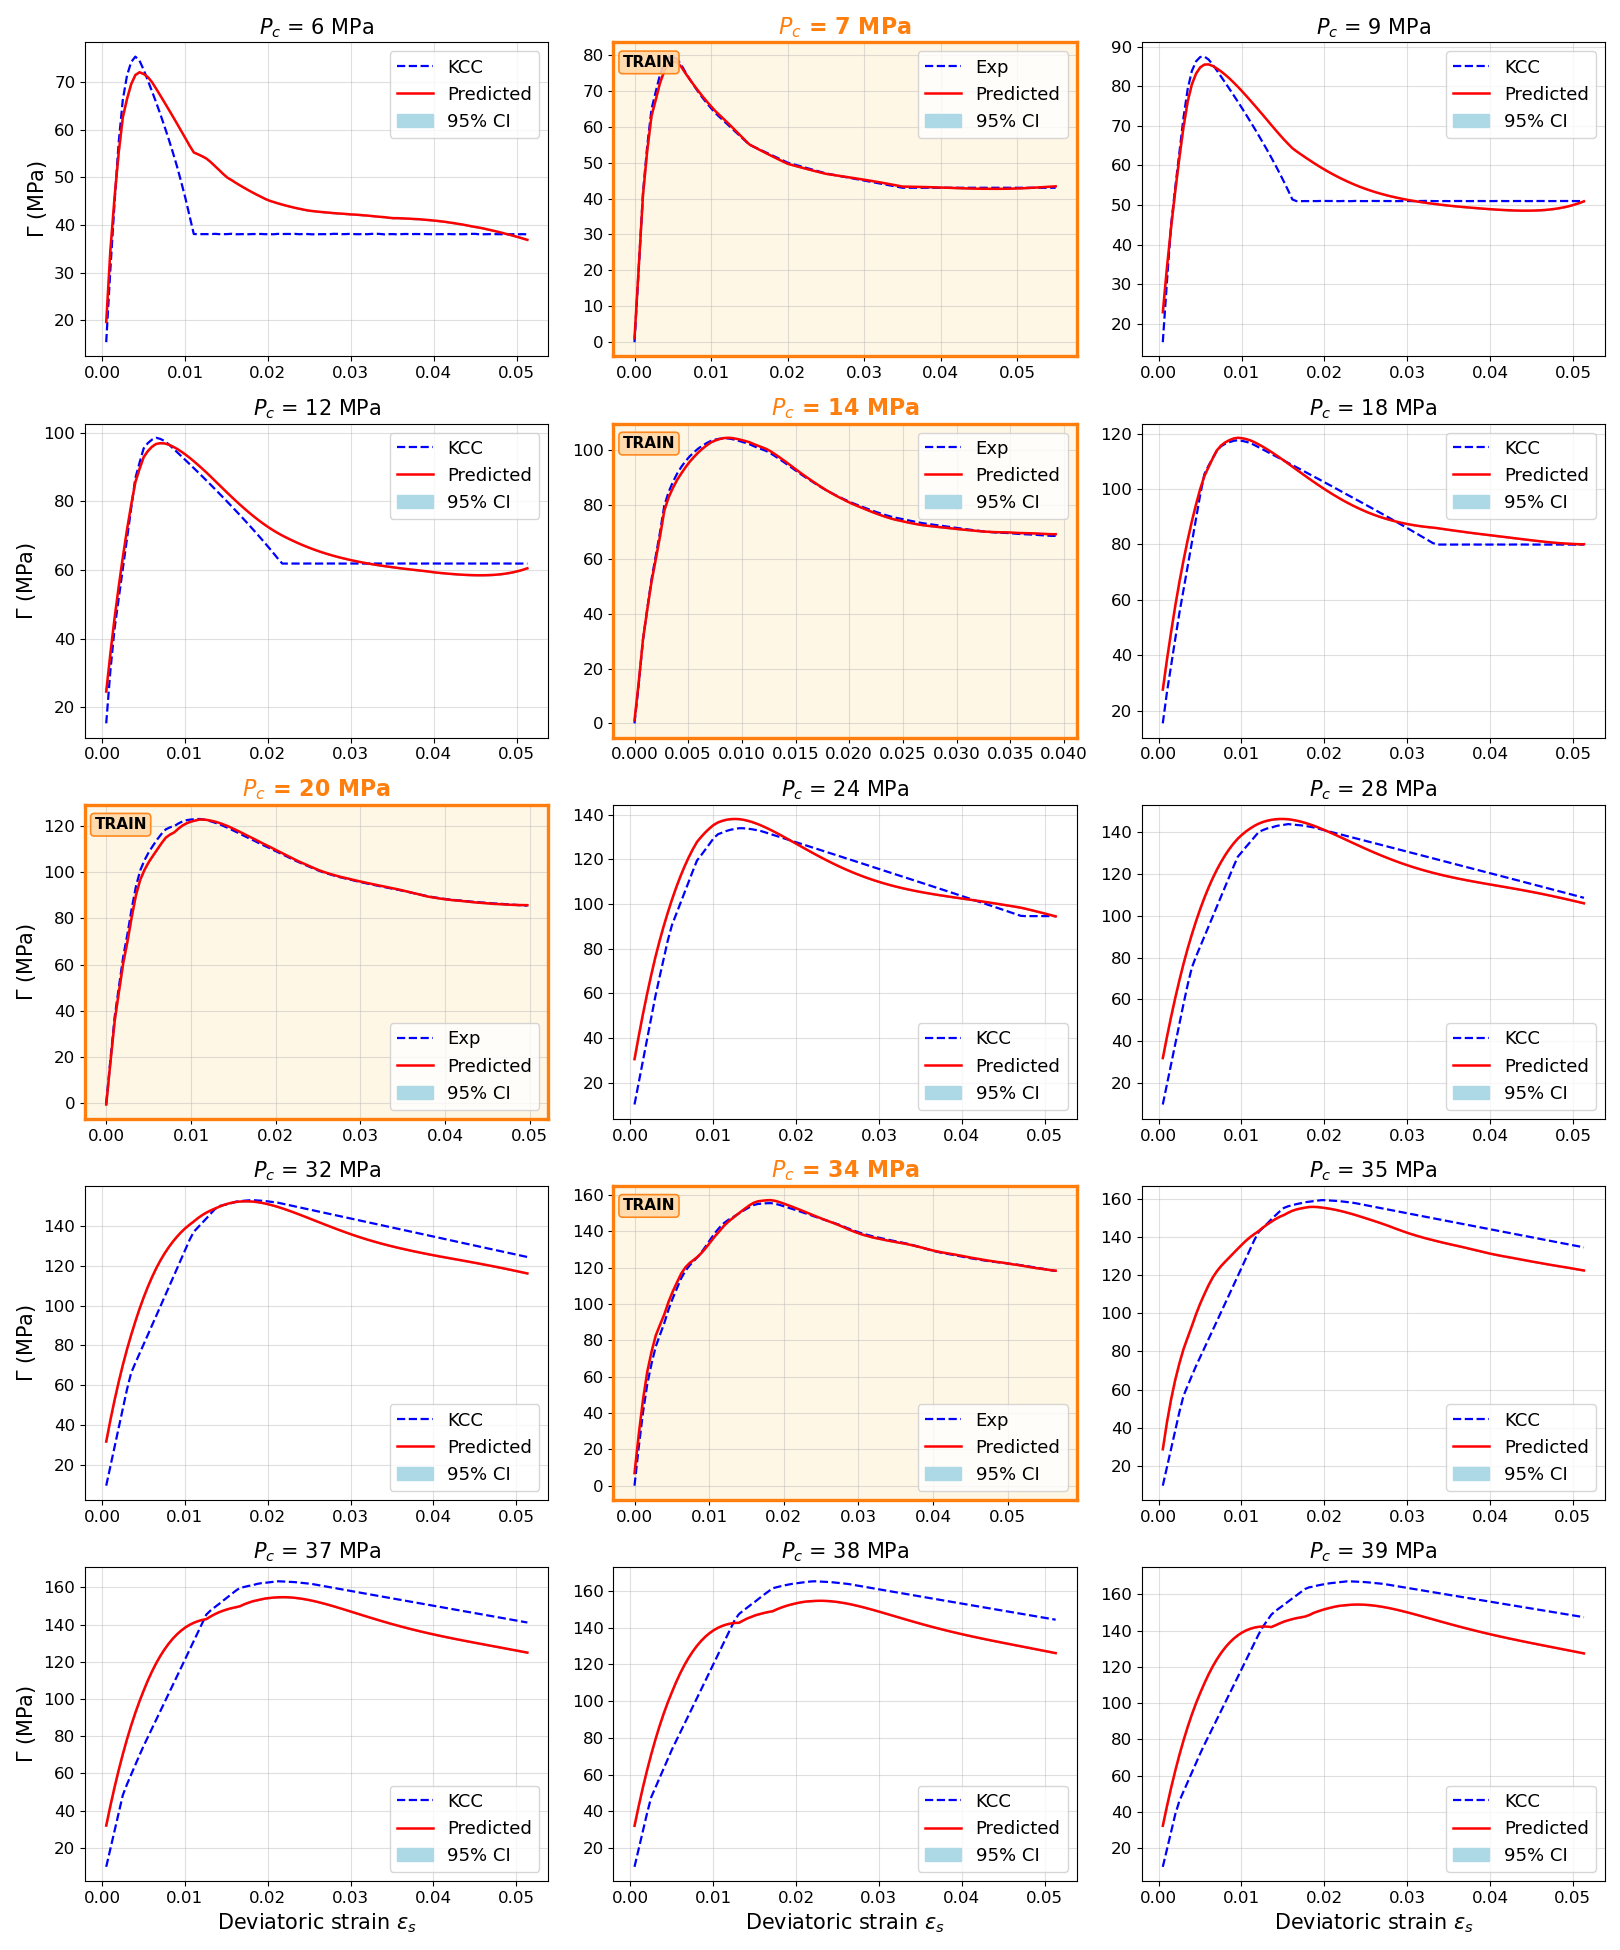

In [219]:
import numpy as np
import matplotlib.pyplot as plt

# assume: X_test, y_test, q_gp, q_std, pc, idx_test, idx_train are already defined

# --- choose which pressure levels (MPa) to show ---
target_pressures = {6, 7, 9, 12, 14, 18, 20, 24, 28, 32, 34, 35, 37, 38, 39}

# figure out how many points per pressure group in X_test ordering
n_groups_all = len(idx_test)
N = X_test.shape[0]
pts_per = N // n_groups_all  # typically 100

# map: panel index i (0..n_groups_all-1) -> actual MPa value
# each panel corresponds to pressure pc[idx_test[i]]
panel_pressures = [float(pc[g]) for g in idx_test]

# pick the panel indices we want to draw (in the same order as idx_test)
selected_panels = [i for i, p in enumerate(panel_pressures) if p in target_pressures]

# layout: 5 rows x 3 cols = 15 panels
nrows, ncols = 5, 3
assert len(selected_panels) <= nrows * ncols, "More panels selected than grid cells!"

# for fast membership check of training groups (by group index in 0..34)
train_set = set(idx_train)

fig, axes = plt.subplots(nrows, ncols, figsize=(5.4*ncols, 3.9*nrows))
axes = np.atleast_2d(axes).ravel()

# iterate over the selected panels and plot each
for j, panel_idx in enumerate(selected_panels):
    ax = axes[j]

    # slice for this pressure panel in X_test/y_test/q_gp
    s = panel_idx * pts_per
    e = s + pts_per

    x      = X_test[s:e, 0]
    y_true = y_test[s:e, 1]
    y_mean = q_gp[s:e]
    y_ci   = 1.96 * q_std[s:e]

    group_idx = idx_test[panel_idx]     # 0..34
    pressure  = panel_pressures[panel_idx]  # MPa
    is_train  = group_idx in train_set

    # label for ground truth curve
    label_true = 'Exp' if is_train else 'KCC'

    # plot curves
    ax.plot(x, y_true, label=label_true, linestyle='dashed', color='blue', linewidth=1.6)
    ax.plot(x, y_mean, label='Predicted', color='red', linewidth=1.8)
    ax.fill_between(x, y_mean - y_ci, y_mean + y_ci, alpha=1, color='lightblue', label='95% CI')

    # title + highlight for training panels
    title_txt = rf'$P_c$ = {pressure:.0f} MPa'
    if is_train:
        ax.set_title(title_txt, fontsize=16, fontweight='bold', color='tab:orange')
        ax.set_facecolor('#fff7e6')
        for sp in ax.spines.values():
            sp.set_linewidth(2.4)
            sp.set_edgecolor('tab:orange')
        ax.text(0.02, 0.96, 'TRAIN', transform=ax.transAxes,
                ha='left', va='top', fontsize=11, fontweight='bold',
                color='black',
                bbox=dict(boxstyle='round,pad=0.25', facecolor='#ffd8a8',
                          edgecolor='tab:orange', linewidth=1.2, alpha=0.9))
    else:
        ax.set_title(title_txt, fontsize=15)

    # cosmetics
    ax.grid(True, alpha=0.4)
    # x/y labels only on bottom row / left column to reduce clutter
    r, c = divmod(j, ncols)
    if r == nrows - 1:
        ax.set_xlabel(r'Deviatoric strain $\epsilon_{s}$', fontsize=15)
    if c == 0:
        ax.set_ylabel(r'$\Gamma$ (MPa)', fontsize=15)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=13, loc='best')

# hide any unused axes (if fewer than 15 selected)
for j in range(len(selected_panels), nrows * ncols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


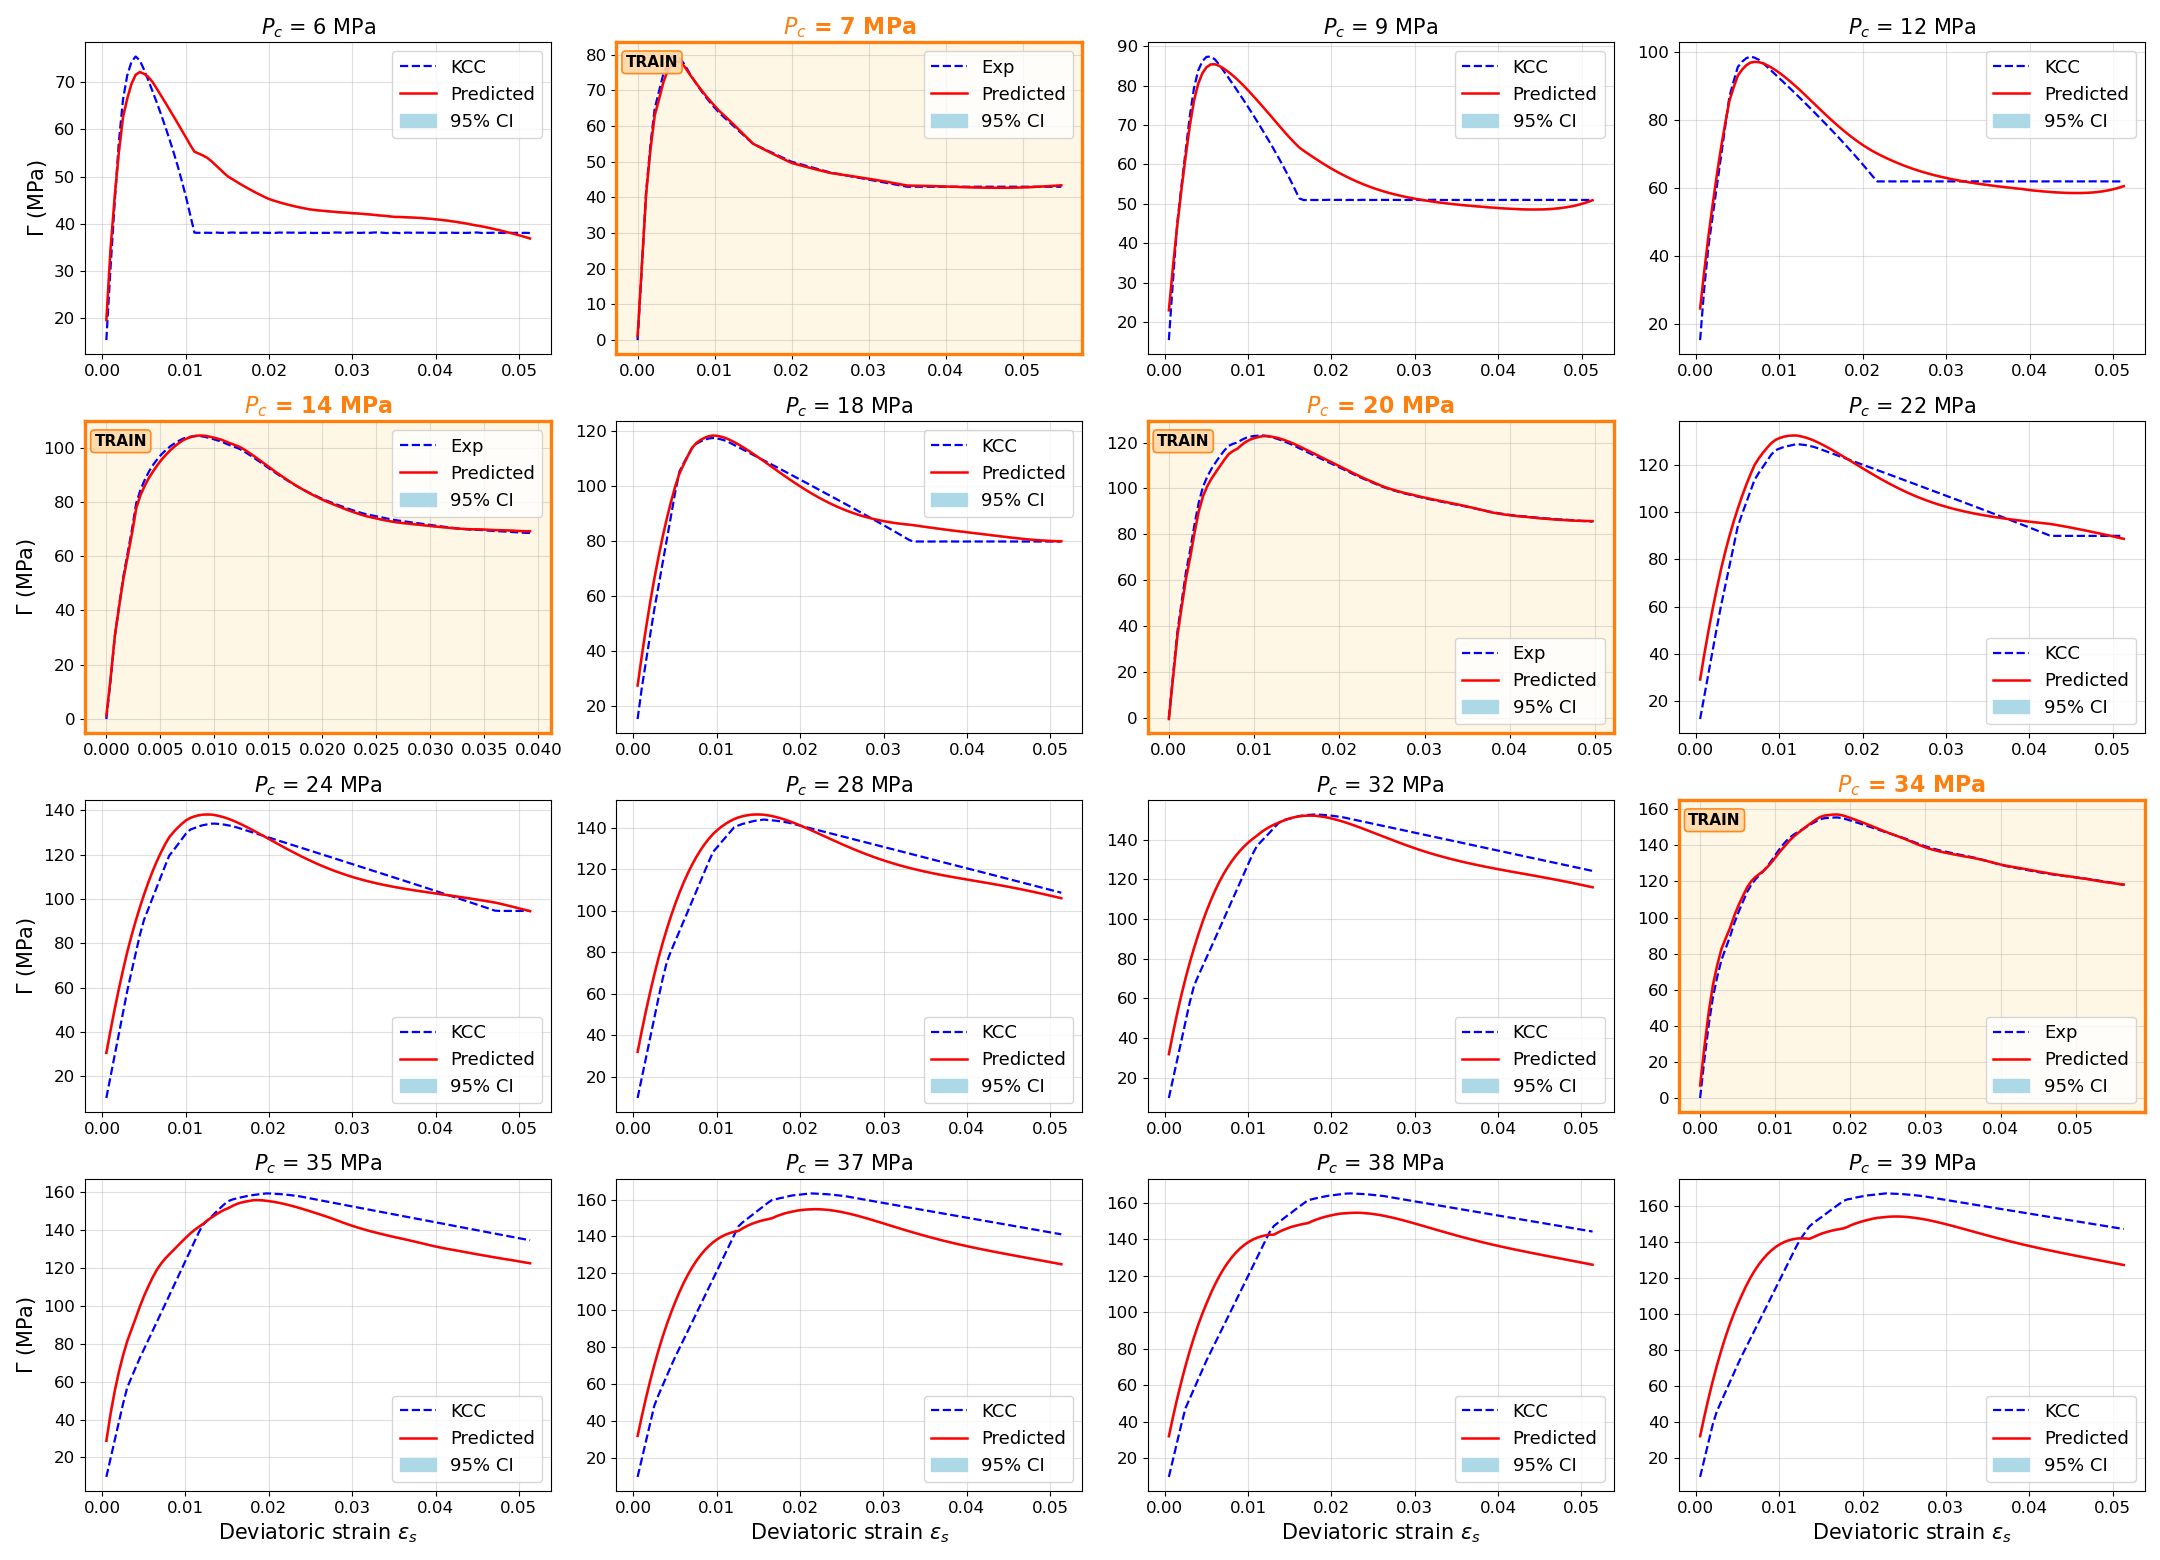

In [222]:
import numpy as np
import matplotlib.pyplot as plt

# assume: X_test, y_test, q_gp, q_std, pc, idx_test, idx_train are already defined

# --- choose which pressure levels (MPa) to show ---
target_pressures = {6, 7, 9, 12, 14, 18, 20, 22, 24, 28, 32, 34, 35, 37, 38, 39}

# figure out how many points per pressure group in X_test ordering
n_groups_all = len(idx_test)
N = X_test.shape[0]
pts_per = N // n_groups_all  # typically 100

# map: panel index i (0..n_groups_all-1) -> actual MPa value
# each panel corresponds to pressure pc[idx_test[i]]
panel_pressures = [float(pc[g]) for g in idx_test]

# pick the panel indices we want to draw (in the same order as idx_test)
selected_panels = [i for i, p in enumerate(panel_pressures) if p in target_pressures]

# layout: 5 rows x 3 cols = 15 panels
nrows, ncols = 4, 4
assert len(selected_panels) <= nrows * ncols, "More panels selected than grid cells!"

# for fast membership check of training groups (by group index in 0..34)
train_set = set(idx_train)

fig, axes = plt.subplots(nrows, ncols, figsize=(5.4*ncols, 3.9*nrows))
axes = np.atleast_2d(axes).ravel()

# iterate over the selected panels and plot each
for j, panel_idx in enumerate(selected_panels):
    ax = axes[j]

    # slice for this pressure panel in X_test/y_test/q_gp
    s = panel_idx * pts_per
    e = s + pts_per

    x      = X_test[s:e, 0]
    y_true = y_test[s:e, 1]
    y_mean = q_gp[s:e]
    y_ci   = 1.96 * q_std[s:e]

    group_idx = idx_test[panel_idx]     # 0..34
    pressure  = panel_pressures[panel_idx]  # MPa
    is_train  = group_idx in train_set

    # label for ground truth curve
    label_true = 'Exp' if is_train else 'KCC'

    # plot curves
    ax.plot(x, y_true, label=label_true, linestyle='dashed', color='blue', linewidth=1.6)
    ax.plot(x, y_mean, label='Predicted', color='red', linewidth=1.8)
    ax.fill_between(x, y_mean - y_ci, y_mean + y_ci, alpha=1, color='lightblue', label='95% CI')

    # title + highlight for training panels
    title_txt = rf'$P_c$ = {pressure:.0f} MPa'
    if is_train:
        ax.set_title(title_txt, fontsize=16, fontweight='bold', color='tab:orange')
        ax.set_facecolor('#fff7e6')
        for sp in ax.spines.values():
            sp.set_linewidth(2.4)
            sp.set_edgecolor('tab:orange')
        ax.text(0.02, 0.96, 'TRAIN', transform=ax.transAxes,
                ha='left', va='top', fontsize=11, fontweight='bold',
                color='black',
                bbox=dict(boxstyle='round,pad=0.25', facecolor='#ffd8a8',
                          edgecolor='tab:orange', linewidth=1.2, alpha=0.9))
    else:
        ax.set_title(title_txt, fontsize=15)

    # cosmetics
    ax.grid(True, alpha=0.4)
    # x/y labels only on bottom row / left column to reduce clutter
    r, c = divmod(j, ncols)
    if r == nrows - 1:
        ax.set_xlabel(r'Deviatoric strain $\epsilon_{s}$', fontsize=15)
    if c == 0:
        ax.set_ylabel(r'$\Gamma$ (MPa)', fontsize=15)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=13, loc='best')

# hide any unused axes (if fewer than 15 selected)
for j in range(len(selected_panels), nrows * ncols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
